In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import load_model

In [2]:
def calculate_difference_image(image1, image2):
    return cv2.absdiff(image1, image2)


In [3]:
def load_images_and_difference(authentic_dir, tampered_dir):
    images = []
    labels = []

    # Load and process authentic images
    print("Loading authentic images...")
    for filename in os.listdir(authentic_dir):
        if filename.lower().endswith(('.jpg', '.bmp')):
            filepath = os.path.join(authentic_dir, filename)
            img = cv2.imread(filepath, cv2.IMREAD_COLOR)
            if img is not None:
                img_resized = cv2.resize(img, (224, 224)).astype(np.float32) / 255.0
                images.append(img_resized)
                labels.append(0)

    print("Loading tampered images and calculating differences...")
    # Process tampered images and calculate differences
    for filename in os.listdir(tampered_dir):
        if filename.lower().endswith(('.jpg', '.tif')):
            tampered_img = cv2.imread(os.path.join(tampered_dir, filename), cv2.IMREAD_COLOR)
            tampered_img_resized = cv2.resize(tampered_img, (224, 224)).astype(np.float32) / 255.0
            
            # Try to find a matching authentic image
            match_found = False
            parts = filename.split("_")
            if len(parts) >= 7:
                source_id = parts[4][:3] + "_" + parts[4][3:]
                target_id = parts[5][:3] + "_" + parts[5][3:]
                for id_ in [source_id, target_id]:
                    for ext in ['.jpg', '.bmp']:
                        auth_filename = f"Au_{id_}{ext}"
                        auth_filepath = os.path.join(authentic_dir, auth_filename)
                        if os.path.exists(auth_filepath):
                            auth_img = cv2.imread(auth_filepath, cv2.IMREAD_COLOR)
                            auth_img_resized = cv2.resize(auth_img, (224, 224)).astype(np.float32) / 255.0
                            difference_img = calculate_difference_image(tampered_img_resized, auth_img_resized)
                            images.append(difference_img)
                            labels.append(1)
                            match_found = True
                            break
            if not match_found:
                print(f"No authentic match found for {filename}, using tampered image directly.")
                images.append(tampered_img_resized)
                labels.append(1)

    return np.array(images), np.array(labels)



In [4]:
authentic_dir = 'D:\Studies\Mini prjt\Mini Project-Final\CASIA2\Au'
tampered_dir = 'D:\Studies\Mini prjt\Mini Project-Final\CASIA2\Tp'

In [5]:
print("Starting image loading process...")
images, labels = load_images_and_difference(authentic_dir, tampered_dir)
print("Image loading complete.")

Starting image loading process...
Loading authentic images...
Loading tampered images and calculating differences...
No authentic match found for Tp_S_CNN_S_N_cha0003_cha00003_00323.tif, using tampered image directly.
No authentic match found for Tp_S_NNN_M_N_pla0006_pla00006_01128.tif, using tampered image directly.
Image loading complete.


In [ ]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
print(f"Train set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

In [6]:
def display_difference_example(authentic_dir, tampered_dir):
    # Pick a random tampered image
    tampered_files = [f for f in os.listdir(tampered_dir) if f.lower().endswith(('.jpg', '.tif'))]
    chosen_file = np.random.choice(tampered_files)
    tampered_img = cv2.imread(os.path.join(tampered_dir, chosen_file), cv2.IMREAD_COLOR)
    tampered_img_resized = cv2.resize(tampered_img, (224, 224))

    # Find its corresponding authentic image
    parts = chosen_file.split("_")
    if len(parts) >= 7:
        source_id = parts[4][:3] + "_" + parts[4][3:]
        target_id = parts[5][:3] + "_" + parts[5][3:]
        for id_ in [source_id, target_id]:
            for ext in ['.jpg', '.bmp']:
                auth_filename = f"Au_{id_}{ext}"
                auth_filepath = os.path.join(authentic_dir, auth_filename)
                if os.path.exists(auth_filepath):
                    auth_img = cv2.imread(auth_filepath, cv2.IMREAD_COLOR)
                    auth_img_resized = cv2.resize(auth_img, (224, 224))

                    # Calculate difference image
                    difference_img = calculate_difference_image(tampered_img_resized, auth_img_resized)

                    # Display images
                    plt.figure(figsize=(12, 4))
                    plt.subplot(1, 3, 1)
                    plt.imshow(cv2.cvtColor(tampered_img_resized, cv2.COLOR_BGR2RGB))
                    plt.title('Tampered Image')
                    plt.axis('off')

                    plt.subplot(1, 3, 2)
                    plt.imshow(cv2.cvtColor(auth_img_resized, cv2.COLOR_BGR2RGB))
                    plt.title('Authentic Image')
                    plt.axis('off')

                    plt.subplot(1, 3, 3)
                    plt.imshow(cv2.cvtColor(difference_img, cv2.COLOR_BGR2RGB))
                    plt.title('Difference Image')
                    plt.axis('off')

                    plt.show()
                    return

    print("No matching example found or unable to load images.")

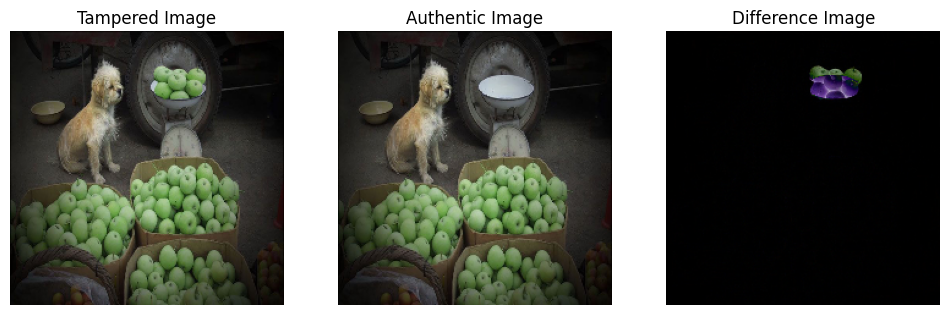

In [7]:
display_difference_example('D:\Studies\Mini prjt\Mini Project-Final\CASIA2\Au', 'D:\Studies\Mini prjt\Mini Project-Final\CASIA2\Tp')

In [14]:
def prepare_single_image(test_image_path, reference_image_path):
    # Load and resize the test image
    test_img = cv2.imread(test_image_path, cv2.IMREAD_COLOR)
    test_img_resized = cv2.resize(test_img, (224, 224)).astype(np.float32) / 255.0

    # Load and resize the reference image
    reference_img = cv2.imread(reference_image_path, cv2.IMREAD_COLOR)
    reference_img_resized = cv2.resize(reference_img, (224, 224)).astype(np.float32) / 255.0

    # Calculate the difference image
    difference_img = calculate_difference_image(test_img_resized, reference_img_resized)
    # Display images
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(test_img_resized, cv2.COLOR_BGR2RGB))
    plt.title('Test Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(reference_img_resized, cv2.COLOR_BGR2RGB))
    plt.title('Reference Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(difference_img, cv2.COLOR_BGR2RGB))
    plt.title('Difference Image')
    plt.axis('off')

    plt.show()
    difference_img = np.expand_dims(difference_img, axis=0)  # Expanding dimensions for the model
    return difference_img

Loaded the entire model from disk.


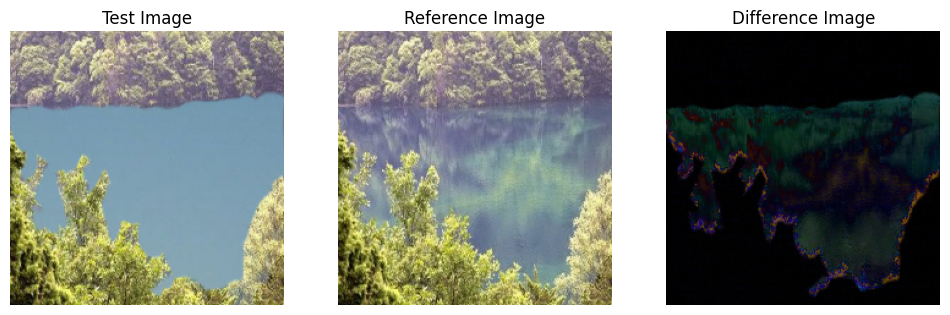

1/1 [==============================] - 0s 253ms/step
Prediction (0 for Authentic, 1 for Tampered): [0.9752564]
The image is likely tampered.


In [15]:
model1 = load_model('VGG16_BC.h5')
print("Loaded the entire model from disk.")

test_image_path = r'D:\Studies\Mini prjt\Mini Project-Final\CASIA2\Tp\Tp_D_CNN_M_N_nat00089_nat00062_10577.jpg'
reference_image_path = r'D:\Studies\Mini prjt\Mini Project-Final\CASIA2\Au\Au_nat_00089.jpg'

try:
    difference_image = prepare_single_image(test_image_path, reference_image_path)
    prediction = model1.predict(difference_image)
    print(f"Prediction (0 for Authentic, 1 for Tampered): {prediction[0]}")
    if prediction[0] > 0.5:
        print("The image is likely tampered.")
    else:
        print("The image is likely authentic.")
except Exception as e:
    print(e)

Loaded the entire model from disk.


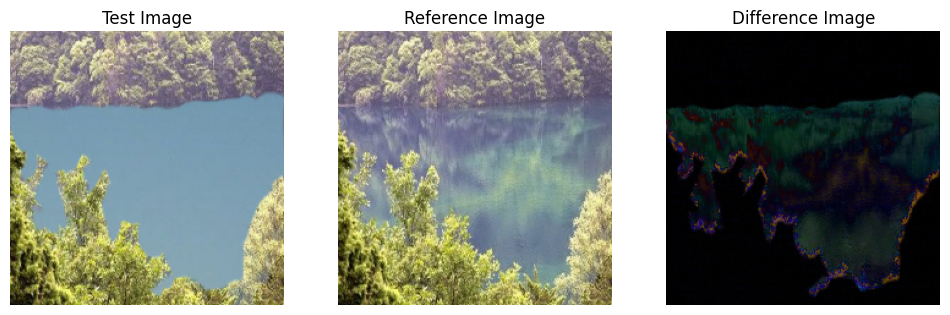

1/1 [==============================] - 3s 3s/step
Prediction (0 for Authentic, 1 for Tampered): [0.99999326]
The image is likely tampered.


In [16]:
model2 = load_model('InceptionResNetV2_BC.h5')
print("Loaded the entire model from disk.")

test_image_path = r'D:\Studies\Mini prjt\Mini Project-Final\CASIA2\Tp\Tp_D_CNN_M_N_nat00089_nat00062_10577.jpg'
reference_image_path = r'D:\Studies\Mini prjt\Mini Project-Final\CASIA2\Au\Au_nat_00089.jpg'

try:
    difference_image = prepare_single_image(test_image_path, reference_image_path)
    prediction = model2.predict(difference_image)
    print(f"Prediction (0 for Authentic, 1 for Tampered): {prediction[0]}")
    if prediction[0] > 0.5:
        print("The image is likely tampered.")
    else:
        print("The image is likely authentic.")
except Exception as e:
    print(e)

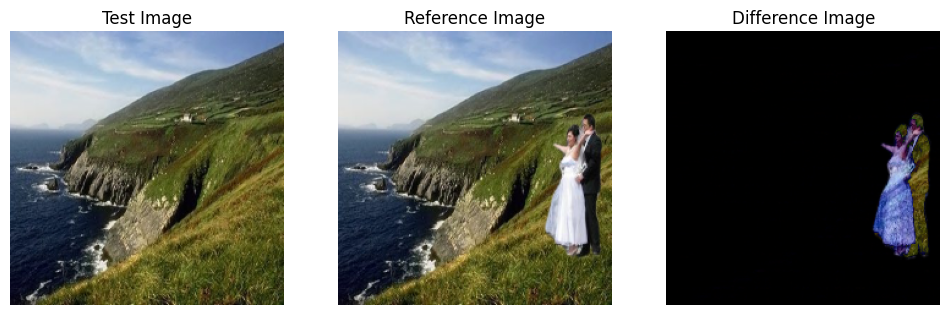

1/1 [==============================] - 1s 617ms/step
Prediction (0 for Authentic, 1 for Tampered): [1.]
The image is likely tampered.


In [18]:
model3 = load_model('MobileNetV2_BC.h5')

test_image_path = 'D:\Studies\Mini prjt\Mini Project-Final\CASIA2\Au\Au_nat_00003.jpg'
reference_image_path = 'D:\Studies\Mini prjt\Mini Project-Final\CASIA2\Tp\Tp_D_NNN_S_N_nat00003_cha00096_00623.tif'

difference_image = prepare_single_image(test_image_path, reference_image_path)
prediction = model3.predict(difference_image)

print(f"Prediction (0 for Authentic, 1 for Tampered): {prediction[0]}")
if prediction[0] > 0.5:
    print("The image is likely tampered.")
else:
    print("The image is likely authentic.")

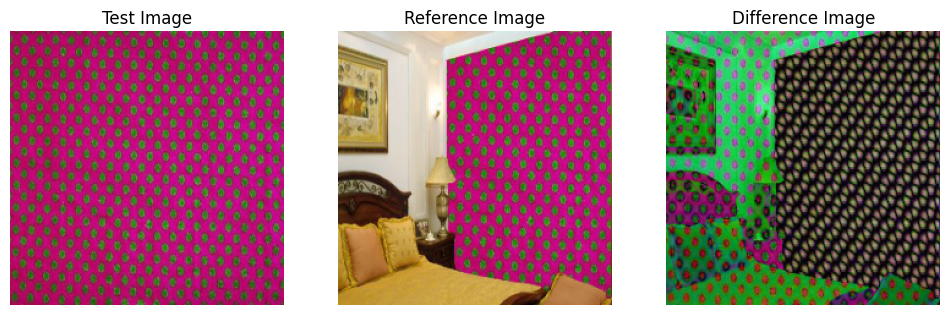

1/1 [==============================] - 2s 2s/step
Prediction (0 for Authentic, 1 for Tampered): [0.00537661]
The image is likely tampered.


In [21]:
model4 = load_model('EfficientNet_BC.h5')

test_image_path = 'D:\Studies\Mini prjt\Mini Project-Final\CASIA2\Au\Au_txt_00065.jpg'
reference_image_path = 'D:\Studies\Mini prjt\Mini Project-Final\CASIA2\Tp\Tp_D_NND_M_B_sec00077_txt00065_10388.tif'

difference_image = prepare_single_image(test_image_path, reference_image_path)
prediction = model4.predict(difference_image)

print(f"Prediction (0 for Authentic, 1 for Tampered): {prediction[0]}")
if prediction[0] < 0.5:
    print("The image is likely tampered.")
else:
    print("The image is likely authentic.")